# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Montreal is the second-most populous city in Canada and the most populous city in the Canadian province of Quebec. The city is a tourist destination with several recreational areas, historic monuments, numerous bars, restaurants, and cafes. An activity that is touristy but also for its residents is drinking coffee. The activity can be done alone, accompanied by friends, and anytime in this city.

Out of 20 countries in the world that drink more coffee per capita, Canadians use about 6.5 kg /year per capita, more than the US and the UK.1 On average, 72% of Canadians between 18 and 79 drink coffee daily but among regular coffee drinkers, the average consumption is 2.8 cups per day ([Coffee Association of Canada](https://coffeebi.com/2020/03/16/coffee-in-canada-habits-and-innovation))

In this project, we will try to find an optimal location for a coffee shop. This report will be targeted at stakeholders who want to start from scratch, buy an existing business, or anybody interested in a good coffee in **Montreal**, Canada.

Since there are lots of coffee shops in Montreal we will try to detect **locations that are not already crowded with coffee shops**. We are also particularly interested in **areas with no coffee shops in the vicinity**. We would also prefer locations **as close to the city center(McGill University neighborhood) as possible**, assuming that the first two conditions are met.


## Data <a name="data"></a>

For the Montreal neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in the city. The data will be scraped from  [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H), and wrangled, cleaned, and then read into the Montreal dataset.

For web scraping, it was used the BeautifulSoup package.

Based on the definition of our problem, factors that will influence our decision are:

* number of existing coffee shops in the neighborhood (any type of coffee shops)
* number of and distance to coffee shops in the neighborhood, if any
* distance of neighborhood from city center

We decided to use a regularly spaced grid of locations, centered around the city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:

* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **pgeocode**, a Python library 


#### Extracting Montreal Data Using a Web Scraping

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

#### Using Webscraping to Extract Montreal Data

In [2]:
# Download the contents of the web
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'

# Use get to download the content of the webpage

html_data = requests.get(url).text

In [3]:
#Parse the html data using beautiful_soup.
soup = BeautifulSoup(html_data,"html5lib")

In [4]:
# Create a list
table_contents = []

In [5]:
table = soup.find('table')


In [6]:
# initialize an empty dictionary to save the data in
postal_codes_dict = {} 
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add only neighborhood to dictionary
            #postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass
    
# create an empty dataframe
columns = ['PostalCode', 'Neighborhood']
montreal_data = pd.DataFrame(columns=columns)
montreal_data



,PostalCode,Neighborhood


In [7]:
# populate dataframe with data from dictionary
for ind, postal_code in enumerate(postal_codes_dict):
    #borough = postal_codes_dict[postal_code]['borough']
    neighborhood = postal_codes_dict[postal_code]['neighborhoods']
    montreal_data = montreal_data.append({"PostalCode": postal_code, 
                                        "Neighborhood": neighborhood},
                                        ignore_index=True)



In [8]:
# print number of rows of dataframe
montreal_data.shape[0]

124

In [9]:
montreal_data.head()

,PostalCode,Neighborhood
0,H1A,Pointe-aux-Trembles
1,H2A,"Saint-Michel,East"
2,H3A,McGill University
3,H4A,Notre-Dame-de-GrâceNortheast
4,H5A,Place Bonaventure


In [10]:
montreal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PostalCode    124 non-null    object
 1   Neighborhood  124 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [11]:
montreal_data.nunique()

PostalCode      124
Neighborhood    124
dtype: int64

#### Get the grographical coordinates (Latitude and Longitude)

In [12]:
# Import package
import pgeocode

nomi = pgeocode.Nominatim('ca')
nomi.query_postal_code("H1A")

postal_code                       H1A
country_code                       CA
place_name        Pointe-Aux-Trembles
state_name                     Quebec
state_code                         QC
county_name                       NaN
county_code                       NaN
community_name                    NaN
community_code                    NaN
latitude                      45.6753
longitude                    -73.5016
accuracy                            4
Name: 0, dtype: object

In [13]:
#Creating a function to use pgeocode

def get_latitude(postal):# get the latitude

  nomi = pgeocode.Nominatim('ca')
  response = nomi.query_postal_code(postal)
  return nomi.query_postal_code(postal)[9]


def get_longitude(postal):# get the longitude

  nomi = pgeocode.Nominatim('ca')
  response = nomi.query_postal_code(postal)
  return nomi.query_postal_code(postal)[10]

In [14]:
montreal_data['Latitude'] = montreal_data.loc[:,'PostalCode'].apply(lambda x: get_latitude(x))
montreal_data['Longitude'] = montreal_data.loc[:,'PostalCode'].apply(lambda x: get_longitude(x))

montreal_data.head()

,PostalCode,Neighborhood,Latitude,Longitude
0,H1A,Pointe-aux-Trembles,45.6753,-73.5016
1,H2A,"Saint-Michel,East",45.5618,-73.5990
2,H3A,McGill University,45.5040,-73.5747
3,H4A,Notre-Dame-de-GrâceNortheast,45.4717,-73.6149
4,H5A,Place Bonaventure,45.4992,-73.5646


#### Cleaning the data

In [15]:
montreal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    124 non-null    object 
 1   Neighborhood  124 non-null    object 
 2   Latitude      123 non-null    float64
 3   Longitude     123 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.0+ KB


In [16]:
montreal_data.isnull().sum()

PostalCode      0
Neighborhood    0
Latitude        1
Longitude       1
dtype: int64

In [17]:
# Show the index of the nulls data

df1 = montreal_data[montreal_data.isna().any(axis=1)]
df1

,PostalCode,Neighborhood,Latitude,Longitude
68,H0P,Not assigned,NaN,NaN


In [18]:
#Remove the row

montreal_data = montreal_data.drop(68, axis=0)


In [19]:
montreal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 123
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    123 non-null    object 
 1   Neighborhood  123 non-null    object 
 2   Latitude      123 non-null    float64
 3   Longitude     123 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.8+ KB


#### Looking for Outliers

<AxesSubplot:xlabel='Latitude'>

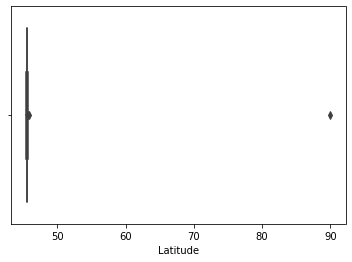

In [20]:
import seaborn as sns

sns.boxplot( x=montreal_data['Latitude'])

<AxesSubplot:xlabel='Longitude'>

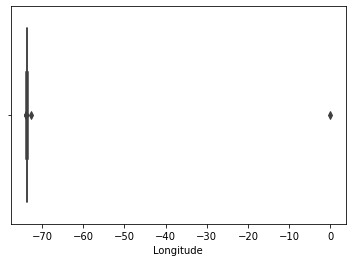

In [21]:
sns.boxplot( x=montreal_data['Longitude'])

Let's remove these outliers in Latitude in Longitude. They don't belong to the same area of others coordinates.

In [22]:
montreal_data = montreal_data[(montreal_data['Latitude'] <= 80)] 
montreal_data = montreal_data[(montreal_data['Longitude'] <= -10)] 

In [23]:
montreal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 0 to 123
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    122 non-null    object 
 1   Neighborhood  122 non-null    object 
 2   Latitude      122 non-null    float64
 3   Longitude     122 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.8+ KB


In [24]:
# Save the data to a csv file
montreal_data.to_csv('montreal_data.csv', index=False)

## Methodology <a name="methodology"></a>

The objective of this project is to find areas of Montreal with a low density of coffee shops.

First, we will check the candidate neighborhoods. It will be created the latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 20x20 killometers centered around the Neighborhood McGill University, Montreal.

Secondly, we will get the top 100 venues that are in McGill University within a radius of 2.5 kilometers and explore their neighborhods. 


#### Let's get the geographical coordinates of McGill university.

In [25]:
montreal_data.loc[montreal_data['Neighborhood']== 'McGill University']

,PostalCode,Neighborhood,Latitude,Longitude
2,H3A,McGill University,45.504,-73.5747


In [28]:
import folium # map rendering library

In [29]:
# create map of Montreal using latitude and longitude values
latitude = 45.504
longitude = -73.5747

map_montreal = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(montreal_data['Latitude'], montreal_data['Longitude'], montreal_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
    
map_montreal

#### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version

In [1]:
CLIENT_ID = 'cliente id' # your Foursquare ID
CLIENT_SECRET = 'cliente secrect' # your Foursquare Secret
ACCESS_TOKEN = 'token' # your FourSquare Access Token
VERSION = 'xxxxxxxx'
LIMIT = 30


Get the neighborhood's latitude and longitude values.

In [31]:
neighborhood_latitude = montreal_data.loc[2, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = montreal_data.loc[2, 'Longitude'] # neighborhood longitude value

neighborhood_name = montreal_data.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of McGill University are 45.504, -73.5747.


#### Now, let's get the top 100 venues that are in McGill University within a radius of 2.5 kilometers.¶

First, let's create the GET request URL. Name your URL url.

In [ ]:
# type your answer here

LIMIT = 100
radius = 2500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

In [ ]:
results = requests.get(url).json()
results

Let's borrow the get_category_type function from the Foursquare lab.

In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [35]:
# Import others libraries

import json
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-35-befcbc7ba862>:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Hôtel Le Germain Montréal - NOW OPEN,Hotel,45.502524,-73.574383
1,Empire,Sporting Goods Shop,45.503952,-73.571840
2,Café Humble Lion,Café,45.503369,-73.575044
3,Frank & Oak,Men's Store,45.499573,-73.574328
4,Café Parvis,Café,45.505817,-73.569302


How many venues were returned by Foursquare?

In [36]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### Explore Neighborhoods in Montreal

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called montreal_venues

In [38]:

montreal_venues = getNearbyVenues(names=montreal_data['Neighborhood'],
                                   latitudes=montreal_data['Latitude'],
                                   longitudes=montreal_data['Longitude']
                                  )

Pointe-aux-Trembles
Saint-Michel,East
McGill University
Notre-Dame-de-GrâceNortheast
Place Bonaventure
Duvernay-Est
Dollard-des-OrmeauxNorthwest
Montreal East
AhuntsicNorth
Downtown MontrealEast
Notre-Dame-de-GrâceSouthwest
Place Desjardins
Saint-François
Dollard-des-OrmeauxEast
Rivière-des-PrairiesNortheast
AhuntsicCentral
Includes Île Notre-Dame & Île Sainte-Hélène
Saint-Henri
Saint-Vincent-de-Paul
L'Île-BizardNortheast
Rivière-des-PrairiesSouthwest
VillerayNortheast
L'Île-Des-Soeurs
Ville Émard
Duvernay
L'Île-BizardSouthwest
Montréal-NordNorth
Petite-PatrieNortheast
Concordia University
VerdunNorth
Pont-Viau
Dollard-des-OrmeauxSouthwest
Montréal-NordSouth
Plateau Mont-RoyalNorth
Downtown MontrealSouthwest
VerdunSouth
AuteuilWest
Sainte-Geneviève / Pierrefonds
AnjouWest
Plateau Mont-RoyalNorth Central
Petite-Bourgogne
CartiervilleCentral
AuteuilNortheast
Kirkland
AnjouEast
Centre-SudNorth
Pointe-Saint-Charles
CartiervilleSouthwest
AuteuilSouth
Senneville
MercierNorth
Centre-SudSouth


In [39]:
#Size of teh dataframe

print(montreal_venues.shape)
montreal_venues.head()

(8772, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pointe-aux-Trembles,45.6753,-73.5016,Parc-nature de la Pointe-aux-Prairies,45.678834,-73.501162,Park
1,Pointe-aux-Trembles,45.6753,-73.5016,Club de Golf de l'île de Montréal,45.685743,-73.511631,Golf Course
2,Pointe-aux-Trembles,45.6753,-73.5016,Dairy Queen,45.696294,-73.491945,Ice Cream Shop
3,Pointe-aux-Trembles,45.6753,-73.5016,IGA,45.658040,-73.509696,Grocery Store
4,Pointe-aux-Trembles,45.6753,-73.5016,Rôtisserie Scores,45.657079,-73.509816,Restaurant


Let's check how many venues were returned for each neighborhood

In [40]:
montreal_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Laval-sur-le-Lac,21,21,21,21,21,21
AhuntsicCentral,100,100,100,100,100,100
AhuntsicEast,100,100,100,100,100,100
AhuntsicNorth,86,86,86,86,86,86
AhuntsicSoutheast,81,81,81,81,81,81
...,...,...,...,...,...,...
Vimont,58,58,58,58,58,58
WestmountNorth,100,100,100,100,100,100
WestmountSouth,100,100,100,100,100,100


#### Analyze Each Neighborhood¶

In [41]:
# one hot encoding
montreal_onehot = pd.get_dummies(montreal_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
montreal_onehot['Neighborhood'] = montreal_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [montreal_onehot.columns[-1]] + list(montreal_onehot.columns[:-1])
montreal_onehot = montreal_onehot[fixed_columns]

montreal_onehot.head()

,Neighborhood,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,...,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
montreal_onehot.shape

(8772, 281)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
montreal_grouped = montreal_onehot.groupby('Neighborhood').mean().reset_index()
montreal_grouped

,Neighborhood,Adult Boutique,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,...,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Laval-sur-le-Lac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0
1,AhuntsicCentral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.010000,0.0,0.010000,0.01,0.00,0.0
2,AhuntsicEast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.020000,0.0,0.010000,0.00,0.00,0.0
3,AhuntsicNorth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.011628,0.0,0.000000,0.00,0.00,0.0
4,AhuntsicSoutheast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.012346,0.0,0.012346,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Vimont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.017241,0.0,0.000000,0.00,0.00,0.0
118,WestmountNorth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,...,0.0,0.01,0.0,0.0,0.010000,0.0,0.010000,0.00,0.02,0.0
119,WestmountSouth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,...,0.0,0.00,0.0,0.0,0.010000,0.0,0.010000,0.00,0.01,0.0
120,YUL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0


#### Select  the coffee shop and others Cafe categories in the data frame 

There are some categories in Foursquare about coffee ( Coffee shop, cafeteria, café, pet cafe, coffe roaster, etc). 

Let's consider select coffee shop category and others two to compare: Cafeteria and Café. 

In [44]:
coffee_df = montreal_grouped[['Neighborhood','Coffee Shop']]

coffee_df.head()

,Neighborhood,Coffee Shop
0,Laval-sur-le-Lac,0.047619
1,AhuntsicCentral,0.040000
2,AhuntsicEast,0.030000
3,AhuntsicNorth,0.034884
4,AhuntsicSoutheast,0.024691


In [45]:
coffee_df.shape

(122, 2)

####  Cluster Neighborhoods

Run k-means to cluster the neighborhood into 4 clusters.

In [46]:
# set number of clusters
kclusters = 4

coffee_grouped_clustering = coffee_df.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(coffee_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 0, 3, 3, 1, 0], dtype=int32)

In [47]:

#make a copy of montreal_data

coffee_merged = coffee_df

# add clustering labels

coffee_merged['Cluster Labels'] = kmeans.labels_

# add latitude/longitude for each neighborhood
coffee_merged = coffee_merged.join(montreal_data.set_index('Neighborhood'), on='Neighborhood')

coffee_merged.head() # check the last columns!

<ipython-input-47-f11a0fc9e851>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee_merged['Cluster Labels'] = kmeans.labels_


,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
0,Laval-sur-le-Lac,0.047619,2,H7R,45.5526,-73.8507
1,AhuntsicCentral,0.040000,2,H2C,45.5606,-73.6584
2,AhuntsicEast,0.030000,2,H2M,45.5528,-73.6411
3,AhuntsicNorth,0.034884,2,H2B,45.5741,-73.6507
4,AhuntsicSoutheast,0.024691,2,H2N,45.5394,-73.6513


In [48]:
# Sort by cluster

coffee_merged.sort_values(['Cluster Labels'], inplace=True)

coffee_merged.head()

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
121,Îles-Laval,0.00,0,H7Y,45.5284,-73.8509
90,Saint-François,0.00,0,H7B,45.6757,-73.6388
66,Old Montreal,0.01,0,H2Y,45.5057,-73.5550
89,RosemontSouth,0.02,0,H1Y,45.5486,-73.5788
35,Downtown MontrealNortheast,0.01,0,H2Z,45.5052,-73.5622


In [49]:
coffee_merged = coffee_merged.reset_index(drop=True)
coffee_merged.head()

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
0,Îles-Laval,0.00,0,H7Y,45.5284,-73.8509
1,Saint-François,0.00,0,H7B,45.6757,-73.6388
2,Old Montreal,0.01,0,H2Y,45.5057,-73.5550
3,RosemontSouth,0.02,0,H1Y,45.5486,-73.5788
4,Downtown MontrealNortheast,0.01,0,H2Z,45.5052,-73.5622


In [50]:
coffee_merged.shape

(122, 6)

#### Resulting Clusters

Finally, let's visualize the resulting clusters

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(coffee_merged['Latitude'], coffee_merged['Longitude'], coffee_merged['Neighborhood'], coffee_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters¶

In [52]:
# minimum frequency of coffee shop
coffee_merged['Coffee Shop'].min()

0.0

In [53]:
# maximum frequency of coffee shop

coffee_merged['Coffee Shop'].max()

0.17857142857142858

#### Cluster 0

In [54]:
coffee_merged.loc[coffee_merged['Cluster Labels'] == 0]

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
0,Îles-Laval,0.000000,0,H7Y,45.5284,-73.8509
1,Saint-François,0.000000,0,H7B,45.6757,-73.6388
2,Old Montreal,0.010000,0,H2Y,45.5057,-73.5550
3,RosemontSouth,0.020000,0,H1Y,45.5486,-73.5788
4,Downtown MontrealNortheast,0.010000,0,H2Z,45.5052,-73.5622
5,RosemontCentral,0.010000,0,H1X,45.5583,-73.5701
6,Duvernay-Est,0.000000,0,H7A,45.6739,-73.5924
7,Includes Île Notre-Dame & Île Sainte-Hélène,0.020000,0,H3C,45.4980,-73.5472
8,L'Île-BizardNortheast,0.000000,0,H9C,45.5055,-73.8789
9,L'Île-BizardSouthwest,0.000000,0,H9E,45.4865,-73.9092


#### Cluster 1

In [55]:
coffee_merged.loc[coffee_merged['Cluster Labels'] == 1]

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
37,AnjouWest,0.110000,1,H1J,45.6097,-73.5794
38,Montreal East,0.117647,1,H1B,45.6320,-73.5075
39,AuteuilSouth,0.117647,1,H7K,45.6213,-73.7398
40,AuteuilWest,0.100000,1,H7H,45.6409,-73.7542
41,DorvalOutskirts,0.119048,1,H9P,45.4679,-73.7748
42,Rivière-des-PrairiesSouthwest,0.137931,1,H1E,45.6342,-73.5842
43,Fabreville,0.121951,1,H7P,45.5780,-73.8004
44,CartiervilleSouthwest,0.119048,1,H4K,45.5171,-73.7363
45,Dorval / L'Île-Dorval,0.178571,1,H9S,45.4414,-73.7749
46,Saint-LaurentSouthwest,0.100000,1,H4S,45.4858,-73.7433


#### Cluster 2

In [56]:
coffee_merged.loc[coffee_merged['Cluster Labels'] == 2]

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
47,Parc-Extension,0.030000,2,H3N,45.5302,-73.6327
48,Petite-Bourgogne,0.050000,2,H3J,45.4861,-73.5732
49,WestmountSouth,0.040000,2,H3Z,45.4825,-73.5933
50,Petite-PatrieSouthwest,0.030000,2,H2S,45.5354,-73.6061
51,VillerayWest,0.049180,2,H2P,45.5435,-73.6339
52,"Pierrefonds-RoxboroRoxboro, A Ma Baie, Cloverd...",0.041667,2,H8Y,45.5084,-73.8075
53,Place Bonaventure,0.030000,2,H5A,45.4992,-73.5646
54,Saint-LaurentOuter Northeast,0.040000,2,H4N,45.5263,-73.6649
55,VilleraySoutheast,0.040000,2,H2R,45.5401,-73.6225
56,Saint-LaurentEast,0.052632,2,H4M,45.4979,-73.6886


#### Cluster 3

In [57]:
coffee_merged.loc[coffee_merged['Cluster Labels'] == 3]

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
96,ChomedeyNortheast,0.080000,3,H7S,45.5793,-73.7367
97,ChomedeyEast,0.070000,3,H7V,45.5478,-73.7368
98,Montreal West,0.060606,3,H4X,45.4529,-73.6492
99,Akwesasne Region1A0: Akwesasne,0.066667,3,H0M,45.6986,-73.5025
100,AnjouEast,0.065789,3,H1K,45.6097,-73.5472
101,VillerayNortheast,0.068966,3,H2E,45.5514,-73.6116
102,Mount RoyalCentral,0.065934,3,H3R,45.5101,-73.6478
103,Vimont,0.086207,3,H7M,45.5984,-73.7159
104,Beaconsfield,0.057692,3,H9W,45.4334,-73.8659
105,Sainte-Rose,0.078947,3,H7L,45.6168,-73.7825


In [58]:
# locations that are not already crowded with coffee shops
low_coffee = (coffee_merged.loc[coffee_merged['Cluster Labels'] == 0]).reset_index(drop=True)
low_coffee.head()

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
0,Îles-Laval,0.00,0,H7Y,45.5284,-73.8509
1,Saint-François,0.00,0,H7B,45.6757,-73.6388
2,Old Montreal,0.01,0,H2Y,45.5057,-73.5550
3,RosemontSouth,0.02,0,H1Y,45.5486,-73.5788
4,Downtown MontrealNortheast,0.01,0,H2Z,45.5052,-73.5622


In [59]:
# locations that are  crowded with coffee shops
high_coffee = (coffee_merged.loc[coffee_merged['Cluster Labels'] == 2]).reset_index(drop=True)
high_coffee.head()

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude
0,Parc-Extension,0.03000,2,H3N,45.5302,-73.6327
1,Petite-Bourgogne,0.05000,2,H3J,45.4861,-73.5732
2,WestmountSouth,0.04000,2,H3Z,45.4825,-73.5933
3,Petite-PatrieSouthwest,0.03000,2,H2S,45.5354,-73.6061
4,VillerayWest,0.04918,2,H2P,45.5435,-73.6339


#### Verify their distance from the McGill University

In [60]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(row):
    lon1 = 45.504
    lat1 = -73.5747
    lon2 = row['Latitude']
    lat2 = row['Longitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

low_coffee['Distance from McGill University (km)'] = low_coffee.apply(lambda row: haversine(row), axis=1)
low_coffee.head()

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude,Distance from McGill University (km)
0,Îles-Laval,0.00,0,H7Y,45.5284,-73.8509,30.702174
1,Saint-François,0.00,0,H7B,45.6757,-73.6388,8.929536
2,Old Montreal,0.01,0,H2Y,45.5057,-73.5550,2.189817
3,RosemontSouth,0.02,0,H1Y,45.5486,-73.5788,1.473474
4,Downtown MontrealNortheast,0.01,0,H2Z,45.5052,-73.5622,1.389576


#### The five neighborhoods closest to mcgill where there is little coffee shop frequency

In [61]:
low_coffee.sort_values(['Distance from McGill University (km)'])[:5]



,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude,Distance from McGill University (km)
15,McGill University,0.01,0,H3A,45.5040,-73.5747,0.000000
34,Concordia University,0.02,0,H3G,45.4987,-73.5793,0.537613
12,Plateau Mont-RoyalSoutheast,0.01,0,H2X,45.5115,-73.5683,0.749244
14,Plateau Mont-RoyalSouth Central,0.02,0,H2W,45.5176,-73.5804,0.764050
29,VerdunNorth,0.01,0,H4G,45.4643,-73.5698,1.361292


#### How far from Mcgill university are the neighborhoods where there are no coffee shops

In [62]:

low_coffee.loc[low_coffee['Coffee Shop']== 0.00].reset_index(drop=True)

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude,Distance from McGill University (km)
0,Îles-Laval,0.0,0,H7Y,45.5284,-73.8509,30.702174
1,Saint-François,0.0,0,H7B,45.6757,-73.6388,8.929536
2,Duvernay-Est,0.0,0,H7A,45.6739,-73.5924,5.686829
3,L'Île-BizardNortheast,0.0,0,H9C,45.5055,-73.8789,33.804292
4,L'Île-BizardSouthwest,0.0,0,H9E,45.4865,-73.9092,37.175337
5,MercierNorth,0.0,0,H1L,45.6043,-73.5178,7.067316
6,YUL,0.0,0,H4Y,45.8654,-72.7614,91.122733
7,Pierrefonds,0.0,0,H8Z,45.5069,-73.8407,29.559418
8,LaSalleSoutheast,0.0,0,H8P,45.4011,-73.6190,5.887405
9,VerdunSouth,0.0,0,H4H,45.4459,-73.5815,1.975503


In [63]:
#Minimum distance

distance_min = low_coffee.loc[low_coffee['Coffee Shop']== 0.00].reset_index(drop=True)

distance_min['Distance from McGill University (km)'].min()

1.9755026334554247

In [64]:
distance_min['Distance from McGill University (km)'].idxmin()

9

In [65]:
high_coffee['Distance from McGill University (km)'] = high_coffee.apply(lambda row: haversine(row), axis=1)
high_coffee.head()

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude,Distance from McGill University (km)
0,Parc-Extension,0.03000,2,H3N,45.5302,-73.6327,6.497443
1,Petite-Bourgogne,0.05000,2,H3J,45.4861,-73.5732,0.586663
2,WestmountSouth,0.04000,2,H3Z,45.4825,-73.5933,2.174418
3,Petite-PatrieSouthwest,0.03000,2,H2S,45.5354,-73.6061,3.625893
4,VillerayWest,0.04918,2,H2P,45.5435,-73.6339,6.694266


In [66]:
high_coffee.loc[high_coffee['Coffee Shop']== 0.17857142857142858].reset_index(drop=True)

,Neighborhood,Coffee Shop,Cluster Labels,PostalCode,Latitude,Longitude,Distance from McGill University (km)


## Results <a name="results"></a>

This work analyzed 122 neighborhoods in Montreal with the objective of detecting places that are no longer full of coffee shops.

The area with the lowest density of cafeterias in Montreal is concentrated in the peripheral region of the analyzed area. This region is related to cluster 0 (red dots on the map).In this cluster, 25 neighborhoods have a low or no cafeteria density.

The neighborhoods where there is a high incidence of coffee shops are located in cluster 1, many of them close to McGill university, our central coordinate.

However, the neighborhoods with the highest coffee frequencies are located in cluster 2, and they are not that close to McGill university. They are regions close to the airport, industrial park and more distant schools. The region with the highest incidence of coffee shops is located in the Dorval / L'Île-Dorval neighborhood and is 22 km away from the university.

VerdunSouth is the closest neighborhood to the McGill university and has no coffee shop. It is 1.97 km away from the central coordinate.

There are also places closer and not crowded with cafes:Plateau Mont-RoyalSoutheast	 ( 0.75km), VerdunNorth (1.36km), Place Desjardins, Downtown MontrealNortheast

## Conclusion <a name="conclusion"></a>

The neighborhoods where there is a high incidence of coffee shops are located in cluster 1, many of them close to McGill university, our central coordinate.

The neighborhoods with the highest coffee frequencies are located in regions close to the airport, industrial park and more distant schools. This makes sense as they are regions of workers who usually consume coffee during their workday. About schools, students' parents usually drink coffee near these places, and if it is university, students have a large consumption of coffee during the year.

Project requirements include detecting places that are not already crowded with cafes, or areas with no cafes nearby, and as close as possible to the city center (McGill University).

The following five options are suggested that meet the project requirements : **VerdunSouth**, the closest neighborhood to the McGill university and has no coffee shop with 1.97 km away from the central coordinate, **Plateau Mont-RoyalSoutheast**( 0.75km), **VerdunNorth** (1.36km), **Place Desjardins(1.38km)**, and **Downtown MontrealNortheast**(1.38km).
